Prithvi EO 2.0 Model Comparison
Foundation (Pretrained) vs Fine-tuned Model Evaluation

This notebook provides a comprehensive comparison between:
1. Foundation Model: Pretrained Prithvi EO 2.0 (no fire-specific training)
2. Fine-tuned Model: Trained model specialized for burn severity

Includes: Metrics, visualizations, and side-by-side predictions

Author: Tushar Thokdar


In [14]:
!pip -q install terratorch
!pip install pytorch-lightning==2.1.0 -q   # Specific Lightning version for stability


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 37.1 MB/s eta 0:00:00


In [34]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split   # ... (metrics and plotting imports)
from tqdm import tqdm
import torch.nn as nn
import segmentation_models_pytorch as smp




from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    accuracy_score
)
from terratorch.models import EncoderDecoderFactory
import seaborn as sns

In [18]:
import gdown

url = "https://drive.google.com/uc?id=1f9OQp5kQ5eem65G6fjUCb5f37KUqurbI" # # The ID of the Google Drive file containing the dataset use your own data

output = "data.zip"

gdown.download(url, output, quiet=False)
import zipfile

with zipfile.ZipFile("data.zip", 'r') as zip_ref: # Unzips contents into a folder named "data"
    zip_ref.extractall("data")

import os

os.remove("data.zip")

Downloading...
From (original): https://drive.google.com/uc?id=1f9OQp5kQ5eem65G6fjUCb5f37KUqurbI
From (redirected): https://drive.google.com/uc?id=1f9OQp5kQ5eem65G6fjUCb5f37KUqurbI&confirm=t&uuid=1320f8bd-476d-4d3b-b026-2f35531c4d51
To: /content/data.zip
100%|██████████| 192M/192M [00:02<00:00, 83.6MB/s]


already finetunes weights are here --- https://drive.google.com/file/d/1pQu1imsz4z1xPzQ3w8wVXM5ToPruDpLE/view?usp=sharing

In [4]:
# ============================================================================
# CONFIGURATION
# ============================================================================

class ComparisonConfig:
    """Configuration for model comparison"""

    # Paths
    DATA_DIR = "/content/data/prithvi_data_final_withdelta"
    FINETUNED_CHECKPOINT = "/content/drive/MyDrive/FIRE ANALYSIS OUTPUT/prithvi-delta-epoch=26-val_loss=1.435.ckpt"

    # Model Settings
    NUM_CLASSES = 5
    NUM_FRAMES = 3  # Set to 3 for delta dataset, 2 for baseline
    IGNORE_INDEX = 255
    BATCH_SIZE = 8
    NUM_WORKERS = 2
    VAL_SPLIT = 0.2

    # Visualization
    NUM_SAMPLES = 6  # Number of visual comparisons to show
    FIGURE_DPI = 150

    # Class Information
    CLASS_NAMES = ['Unburned', 'Low Severity', 'Moderate-Low', 'Moderate-High', 'High Severity']
    CLASS_COLORS = ['#1a9850', '#fee08b', '#fdae61', '#f46d43', '#a50026']
    # Green → Yellow → Orange → Red → Dark Red

In [5]:
# ============================================================================
# SETUP
# ============================================================================

def setup_device():
    """Setup compute device"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🖥️  Using device: {device}")
    if device == "cuda":
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
    return device

def create_colormap(config):
    """Create colormap for severity visualization"""
    cmap = mcolors.ListedColormap(config.CLASS_COLORS)
    norm = mcolors.BoundaryNorm(
        np.arange(-0.5, config.NUM_CLASSES + 0.5),
        config.NUM_CLASSES
    )
    return cmap, norm


In [22]:
# ============================================================================
# DATA MODULE
# ============================================================================

class FireSeverityDataModule(pl.LightningDataModule):  #This inherits from PyTorch Lightning. It standardizes how data is loaded, making the code cleaner and easier to share.
    """Data module for fire severity dataset"""

    def __init__(self, data_dir, batch_size=8, num_workers=2, val_split=0.2):
        super().__init__()
        # Storing configuration variables

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split = val_split
        # Define where the images and masks are located inside the main data folder

        self.image_dir = os.path.join(data_dir, 'temporal_images')
        self.mask_dir = os.path.join(data_dir, 'masks')

    def setup(self, stage=None):
        # 1. Get a list of every single file in the image directory
        all_files = os.listdir(self.image_dir)
        # 2. Clean the filenames to get just the ID (e.g., remove ".npy")
        all_chip_ids = [f.replace('.npy', '') for f in all_files]
        # 3. Randomly split the IDs into two lists: Train (80%) and Val (20%)
        # random_state=42 ensures the split is the same every time you run it.
        train_ids, val_ids = train_test_split(
            all_chip_ids, test_size=self.val_split, random_state=42
        )
        # 4. Create the actual Dataset objects using the lists of IDs we just made
        self.train_dataset = FireSeverityDataset(
            self.image_dir, self.mask_dir, train_ids
        )
        self.val_dataset = FireSeverityDataset(
            self.image_dir, self.mask_dir, val_ids
        )
        # Print stats so you know it worked
        print(f"✅ Train: {len(self.train_dataset)} samples")
        print(f"✅ Val: {len(self.val_dataset)} samples")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,   # e.g., 8 images at a time
            shuffle=True,   # IMPORTANT: Shuffles data every epoch so the model doesn't memorize the order
            num_workers=self.num_workers,   # Uses 2 CPU cores to prepare data in parallel
            pin_memory=True,    # Speeds up transfer from CPU RAM to GPU RAM
            # Keeps the CPU workers alive between epochs to save startup time
            persistent_workers=True if self.num_workers > 0 else False
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,   # IMPORTANT: We do NOT shuffle validation data. We want consistent results.
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
class FireSeverityDataset(Dataset):
    """Dataset for temporal fire severity prediction"""

    def __init__(self, image_dir, mask_dir, chip_ids):
    # Stores the folder paths and the list of file IDs (chip_ids)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.chip_ids = chip_ids

    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):
        chip_id = self.chip_ids[idx]
        # Loads the input image (Satellite data)
        # Shape: (3, 6, 224, 224) -> 3 Time steps, 6 Spectral Bands, Height, Width

        # ✅ CHANGE: Now loads (3, 6, 224, 224) instead of (2, 6, 224, 224)
        image = np.load(os.path.join(self.image_dir, f"{chip_id}.npy"))

        # Loads the target mask (The ground truth map of fire severity)

        mask = np.load(os.path.join(self.mask_dir, f"{chip_id}.npy"))

        # Converts Numpy arrays to PyTorch Tensors (Float for images, Long/Integer for masks)
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()

        return {'image': image, 'mask': mask}


In [26]:
# ============================================================================
# COMPUTE CLASS WEIGHTS
# ============================================================================

def compute_class_weights(data_dir, ignore_index=255):
  # ... (code iterates through all mask files) ...
    """Compute class weights from dataset"""
    print("\n📊 Computing class weights...")

    mask_dir = os.path.join(data_dir, 'masks')
    all_labels = []

    for mask_file in tqdm(os.listdir(mask_dir), desc="Scanning masks"):
        mask = np.load(os.path.join(mask_dir, mask_file))
        valid_pixels = mask[mask != ignore_index]
        all_labels.extend(valid_pixels.tolist())
    # Calculates how frequent each class is
    unique, counts = np.unique(all_labels, return_counts=True)
    print(f"\nClass distribution: {dict(zip(unique, counts))}")

    # Compute balanced weights
    total = len(all_labels)
    num_classes = 5
    weights = []

    for cls in range(num_classes):
        if cls in unique:
            cls_count = counts[unique == cls][0]
        # Formula: Total_Pixels / (Num_Classes * Count_of_Specific_Class)
        # This gives rare classes a HIGHER weight and common classes a LOWER weight.
            weight = total / (num_classes * cls_count)
        else:
            weight = 1.0
        weights.append(weight)

    weights = torch.tensor(weights, dtype=torch.float32)
    print(f"Class weights: {weights.numpy()}")

    return weights


In [30]:
# ============================================================================
# CHANGE 2: Update Model to Accept 3 Frames
# ============================================================================

class PrithviFireSegmentation(pl.LightningModule):
    """Lightning module with delta channel support"""

    def __init__(
        self,
        num_classes=5,
        learning_rate=1e-4,
        weight_decay=0.01,
        class_weights=None,
        ignore_index=255,
        freeze_backbone_epochs=5
    ):
        super().__init__()
        # Saves parameters like 'learning_rate' so they are logged to TensorBoard automatically
        self.save_hyperparameters(ignore=['class_weights'])
        # We will freeze the main "brain" (backbone) for the first 5 epochs
        self.freeze_backbone_epochs = freeze_backbone_epochs
        self.backbone_frozen = True

        # Build model
        factory = EncoderDecoderFactory()
        self.model = factory.build_model(
            task="segmentation",    #The specific task here its segmentation (other ex. classification)
            backbone="prithvi_eo_v2_tiny_tl",   # The specific Foundation Model version
            decoder="UperNetDecoder",   # A sophisticated head for segmentation
            num_classes=num_classes,   # 5 classes: Unburned, Low, Moderate, High, Extreme
            backbone_kwargs={
                "in_channels": 6,  # Blue, Green, Red, NIR, SWIR1, SWIR2
                "pretrained": True,  # Download weights pre-trained on global data
                "num_frames": 3  # IMPORTANT: 3 frames (Pre, Post, Delta) (delta = post - pre)
            }
        )

        # Register class weights
        if class_weights is not None:
            self.register_buffer("class_weights", class_weights)
        else:
            self.class_weights = None
        # 1. CrossEntropyLoss: Good for general classification.
        # We use class_weights to tell it to pay more attention to rare classes (Extreme Fire).
        self.ce_loss = nn.CrossEntropyLoss(
            weight=self.class_weights,
            ignore_index=ignore_index
        )
        # 2. DiceLoss: Good for segmentation.
        # It cares about the "overlap" shapes. It ignores the background (Unburned)
        # and focuses on getting the burn shapes correct.
        self.dice_loss = smp.losses.DiceLoss(
            mode="multiclass",
            from_logits=True,
            ignore_index=ignore_index,
            classes=[1, 2, 3, 4]
        )

    def forward(self, x):
        # Transpose from (B, T, C, H, W) to (B, C, T, H, W)
        # Input x comes in as: (Batch, Time=3, Channels=6, Height, Width)
        # Prithvi expects:     (Batch, Channels=6, Time=3, Height, Width)

        # The .permute() command rearranges the dimensions to match what Prithvi wants.
        x = x.permute(0, 2, 1, 3, 4)

        # We pass the rearranged data into the model
        output = self.model(x)

        # Safety check: Different versions of the library return output differently.
        # This block ensures we just extract the raw prediction scores (logits).

        if hasattr(output, 'output'):
            return output.output
        elif isinstance(output, dict):
            return output['output']
        else:
            return output

    # The following multi-line comment block was causing an indentation issue.
    # It has been moved to be part of the `on_train_epoch_start` method's docstring
    # or removed if it was only a general comment.

    def on_train_epoch_start(self):
        """Unfreeze backbone after specified epochs
        This is a sophisticated fine-tuning technique. We don't want to destroy the pre-trained knowledge immediately.

        Epoch 0-5: We freeze the "Backbone" (the deep brain). We only update the "Decoder" (the eyes/hands).
        This aligns the new fire tasks with the pre-existing knowledge.

        Epoch 5+: We unfreeze the backbone and let the whole model learn.
        """
        # If we hit epoch 5, we unlock the backbone
        if self.backbone_frozen and self.current_epoch >= self.freeze_backbone_epochs:
            print(f"\n🔓 Unfreezing backbone at epoch {self.current_epoch}")
            # ✅ FIX: Access encoder instead of backbone
            if hasattr(self.model, 'encoder'):
              # Turn gradients back ON. Now the Foundation Model itself adapts to fire data.
                for param in self.model.encoder.parameters():
                    param.requires_grad = True
            elif hasattr(self.model, 'backbone'):
                for param in self.model.backbone.parameters():
                    param.requires_grad = True
            else:
                # Fallback: unfreeze all parameters
                for param in self.model.parameters():
                    param.requires_grad = True
            self.backbone_frozen = False

    def on_train_start(self):
        """Freeze backbone initially"""
        print(f"🔒 Freezing backbone for first {self.freeze_backbone_epochs} epochs")
        # Iterate through the encoder/backbone parameters and turn off gradients.
        # The model will NOT learn here, preserving pre-trained weights.
        # ✅ FIX: Access encoder instead of backbone
        if hasattr(self.model, 'encoder'):
            for param in self.model.encoder.parameters():
                param.requires_grad = False
        elif hasattr(self.model, 'backbone'):
            for param in self.model.backbone.parameters():
                param.requires_grad = False
        else:
            print("⚠️ Could not find encoder/backbone - training all parameters from start")

    def training_step(self, batch, batch_idx):
        images, masks = batch['image'], batch['mask']

        # ✅ CHANGE: Update validation
        # 🚨 SAFETY CHECK: Ensure we are actually feeding 3 time steps (Pre, Post, Delta)
        assert images.shape[1] == 3, f"Expected 3 time steps, got {images.shape[1]}"  # Changed from 2 to 3
        assert images.shape[2] == 6, f"Expected 6 channels, got {images.shape[2]}"
        # 1. Guess: Ask the model for predictions (logits)
        logits = self(images)
        # 2. Grade: Calculate how wrong the model is
        ce_loss = self.ce_loss(logits, masks)
        dice_loss = self.dice_loss(logits, masks)
        # Combine losses. We give Dice loss 0.8 weight to emphasize accurate shapes.
        #loss = ce_loss + 0.5 * dice_loss
        loss = ce_loss + 0.8 * dice_loss


        # Accuracy on valid pixels only
        # 3. Check Accuracy:
        # We ignore "255" pixels (invalid data) when calculating accuracy
        valid_mask = masks != 255
        if valid_mask.sum() > 0:
            preds = torch.argmax(logits, dim=1)
            accuracy = (preds[valid_mask] == masks[valid_mask]).float().mean()
        else:
            accuracy = torch.tensor(0.0)

        # 4. Report Card: Send stats to the progress bar and logs
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_ce', ce_loss, on_step=False, on_epoch=True)
        self.log('train_dice', dice_loss, on_step=False, on_epoch=True)
        self.log('train_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True)

        return loss   # The optimizer uses this value to update weights

    def validation_step(self, batch, batch_idx):
        """
        This runs at the end of every epoch. It is the "Exam" phase.
        It uses the same logic as training, but it doesn't update the model weights.
        """
        images, masks = batch['image'], batch['mask']

        logits = self(images)

        ce_loss = self.ce_loss(logits, masks)
        dice_loss = self.dice_loss(logits, masks)
        loss = ce_loss + 0.8 * dice_loss

        valid_mask = masks != 255
        if valid_mask.sum() > 0:
            preds = torch.argmax(logits, dim=1)
            accuracy = (preds[valid_mask] == masks[valid_mask]).float().mean()
        else:
            accuracy = torch.tensor(0.0)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)   #Used by EarlyStopping to decide when to quit
        self.log('val_ce', ce_loss, on_epoch=True)
        self.log('val_dice', dice_loss, on_epoch=True)
        self.log('val_acc', accuracy, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
      # AdamW is a standard, robust optimizer for Transformers
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        # Scheduler: Cosine Annealing
        # Start with a high learning rate, then slowly lower it in a wave pattern.
        # This helps the model settle into a good solution without overshooting.
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=30, eta_min=1e-6
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler, 'interval': 'epoch'}
        }


In [6]:
# ============================================================================
# MODEL LOADING
# ============================================================================

def load_foundation_model(config, device):
    """
    Load pretrained foundation model (no fine-tuning)

    Args:
        config: Configuration object
        device: Compute device

    Returns:
        Foundation model ready for evaluation
    """
    print("\n" + "="*80)
    print("🔵 LOADING FOUNDATION MODEL (Pretrained Only)")
    print("="*80)

    factory = EncoderDecoderFactory()
    model = factory.build_model(
        task="segmentation",
        backbone="prithvi_eo_v2_tiny_tl",
        decoder="UperNetDecoder",
        num_classes=config.NUM_CLASSES,
        backbone_kwargs={
            "in_channels": 6,
            "pretrained": True,  # Use pretrained weights
            "num_frames": config.NUM_FRAMES
        }
    )

    model.eval()
    model.to(device)

    print(f"✅ Foundation model loaded")
    print(f"   Backbone: Prithvi EO 2.0 Tiny (Pretrained)")
    print(f"   Decoder: UperNet")
    print(f"   Classes: {config.NUM_CLASSES}")
    print(f"   Frames: {config.NUM_FRAMES}")

    return model


def load_finetuned_model(checkpoint_path, class_weights, device):
    """
    Load fine-tuned model from checkpoint

    Args:
        checkpoint_path: Path to checkpoint file
        class_weights: Class weights for loss
        device: Compute device

    Returns:
        Fine-tuned model ready for evaluation
    """
    print("\n" + "="*80)
    print("🟢 LOADING FINE-TUNED MODEL")
    print("="*80)

    # Assuming PrithviFireSegmentation is defined elsewhere
    model = PrithviFireSegmentation.load_from_checkpoint(
        checkpoint_path,
        class_weights=class_weights
    )

    model.eval()
    model.to(device)

    print(f"✅ Fine-tuned model loaded")
    print(f"   Checkpoint: {Path(checkpoint_path).name}")

    return model


In [7]:
# ============================================================================
# PREDICTION UTILITIES
# ============================================================================

def extract_logits(output):
    """
    Extract logits from model output (handles different formats)

    Args:
        output: Model output (various formats)

    Returns:
        Logits tensor
    """
    if hasattr(output, "output"):
        return output.output
    if isinstance(output, dict):
        return output["output"]
    return output


def get_predictions(model, images, permute=False, device="cuda"):
    """
    Get model predictions for a batch

    Args:
        model: Model to evaluate
        images: Input images
        permute: Whether to permute dimensions for foundation model
        device: Compute device

    Returns:
        Predicted class indices
    """
    with torch.no_grad():
        if permute:
            # Foundation model expects (B, C, T, H, W)
            images = images.permute(0, 2, 1, 3, 4)

        logits = extract_logits(model(images))
        preds = torch.argmax(logits, dim=1)

    return preds


In [8]:
# ============================================================================
# EVALUATION
# ============================================================================

class ModelEvaluator:
    """Evaluate model and collect metrics"""

    def __init__(self, config):
        self.config = config
        self.preds = []
        self.targets = []

    def evaluate_batch(self, model, batch, permute=False, device="cuda"):
        """Evaluate single batch"""
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        preds = get_predictions(model, images, permute=permute, device=device)

        # Only valid pixels (ignore 255)
        valid = masks != self.config.IGNORE_INDEX

        self.preds.append(preds[valid].cpu().numpy())
        self.targets.append(masks[valid].cpu().numpy())

    def evaluate_dataloader(self, model, dataloader, permute=False, device="cuda"):
        """Evaluate entire dataloader"""
        print(f"   Processing {len(dataloader)} batches...")

        for batch in dataloader:
            self.evaluate_batch(model, batch, permute=permute, device=device)

        # Concatenate all predictions
        self.preds = np.concatenate(self.preds)
        self.targets = np.concatenate(self.targets)

        print(f"   ✅ Evaluated {len(self.preds):,} pixels")

    def compute_metrics(self):
        """Compute comprehensive metrics"""
        metrics = {}

        # Overall metrics
        metrics['accuracy'] = accuracy_score(self.targets, self.preds)
        metrics['macro_f1'] = f1_score(self.targets, self.preds, average='macro', zero_division=0)
        metrics['weighted_f1'] = f1_score(self.targets, self.preds, average='weighted', zero_division=0)

        # Per-class F1
        metrics['per_class_f1'] = f1_score(
            self.targets, self.preds,
            average=None,
            labels=list(range(self.config.NUM_CLASSES)),
            zero_division=0
        )

        # Burned pixels only (classes 1-4)
        burned_mask = self.targets > 0
        if burned_mask.sum() > 0:
            metrics['burned_f1'] = f1_score(
                self.targets[burned_mask],
                self.preds[burned_mask],
                average='macro',
                labels=[1, 2, 3, 4],
                zero_division=0
            )
        else:
            metrics['burned_f1'] = 0.0

        # Confusion matrix
        metrics['confusion_matrix'] = confusion_matrix(
            self.targets, self.preds,
            labels=list(range(self.config.NUM_CLASSES))
        )

        return metrics

    def print_distribution(self):
        """Print prediction distribution"""
        unique, counts = np.unique(self.preds, return_counts=True)
        total = len(self.preds)

        print("\n   Prediction Distribution:")
        for cls, count in zip(unique, counts):
            pct = count / total * 100
            print(f"      Class {cls} ({self.config.CLASS_NAMES[cls]}): {pct:5.1f}%")


def run_comparison(foundation_model, finetuned_model, dataloader, config, device):
    """
    Run complete comparison between models

    Args:
        foundation_model: Pretrained model
        finetuned_model: Fine-tuned model
        dataloader: Validation dataloader
        config: Configuration
        device: Compute device

    Returns:
        Dictionary with results for both models
    """
    print("\n" + "="*80)
    print("📊 RUNNING MODEL COMPARISON")
    print("="*80)

    # Evaluate foundation model
    print("\n🔵 Evaluating Foundation Model...")
    foundation_eval = ModelEvaluator(config)
    foundation_eval.evaluate_dataloader(foundation_model, dataloader, permute=True, device=device)
    foundation_metrics = foundation_eval.compute_metrics()
    foundation_eval.print_distribution()

    # Evaluate fine-tuned model
    print("\n🟢 Evaluating Fine-tuned Model...")
    finetuned_eval = ModelEvaluator(config)
    finetuned_eval.evaluate_dataloader(finetuned_model, dataloader, permute=False, device=device)
    finetuned_metrics = finetuned_eval.compute_metrics()
    finetuned_eval.print_distribution()

    return {
        'foundation': {
            'metrics': foundation_metrics,
            'evaluator': foundation_eval
        },
        'finetuned': {
            'metrics': finetuned_metrics,
            'evaluator': finetuned_eval
        }
    }


In [9]:
# ============================================================================
# RESULTS DISPLAY
# ============================================================================

def print_metric_comparison(results, config):
    """Print detailed metric comparison"""
    print("\n" + "="*80)
    print("📊 METRIC COMPARISON")
    print("="*80)

    f_metrics = results['foundation']['metrics']
    t_metrics = results['finetuned']['metrics']

    # Overall metrics
    print(f"\n{'Metric':<20} {'Foundation':<12} {'Fine-tuned':<12} {'Improvement'}")
    print("-" * 60)

    metrics_to_compare = [
        ('Accuracy', 'accuracy'),
        ('Macro F1', 'macro_f1'),
        ('Weighted F1', 'weighted_f1'),
        ('Burned F1', 'burned_f1')
    ]

    for name, key in metrics_to_compare:
        f_val = f_metrics[key]
        t_val = t_metrics[key]
        diff = (t_val - f_val) * 100
        print(f"{name:<20} {f_val:<12.4f} {t_val:<12.4f} {diff:+6.2f}%")

    # Per-class comparison
    print(f"\n{'Class':<20} {'Foundation':<12} {'Fine-tuned':<12} {'Improvement'}")
    print("-" * 60)

    for i, name in enumerate(config.CLASS_NAMES):
        f_val = f_metrics['per_class_f1'][i]
        t_val = t_metrics['per_class_f1'][i]
        diff = (t_val - f_val) * 100
        print(f"{name:<20} {f_val:<12.4f} {t_val:<12.4f} {diff:+6.2f}%")


def print_classification_reports(results, config):
    """Print detailed classification reports"""
    f_eval = results['foundation']['evaluator']
    t_eval = results['finetuned']['evaluator']

    print("\n" + "="*80)
    print("📋 FOUNDATION MODEL - Classification Report")
    print("="*80)
    print(classification_report(
        f_eval.targets,
        f_eval.preds,
        target_names=config.CLASS_NAMES,
        digits=4,
        zero_division=0
    ))

    print("\n" + "="*80)
    print("📋 FINE-TUNED MODEL - Classification Report")
    print("="*80)
    print(classification_report(
        t_eval.targets,
        t_eval.preds,
        target_names=config.CLASS_NAMES,
        digits=4,
        zero_division=0
    ))


def print_verdict(results):
    """Print final verdict on fine-tuning effectiveness"""
    print("\n" + "="*80)
    print("💡 VERDICT")
    print("="*80)

    f_f1 = results['foundation']['metrics']['macro_f1']
    t_f1 = results['finetuned']['metrics']['macro_f1']
    improvement = (t_f1 - f_f1) * 100

    if improvement > 20:
        verdict = "🎉 Fine-tuning provides HUGE improvement!"
        quality = "excellent"
    elif improvement > 10:
        verdict = "✅ Fine-tuning provides significant improvement."
        quality = "very good"
    elif improvement > 5:
        verdict = "👍 Fine-tuning provides moderate improvement."
        quality = "good"
    elif improvement > 0:
        verdict = "⚠️  Fine-tuning provides minimal improvement."
        quality = "marginal"
    else:
        verdict = "❌ Fine-tuning hurt performance - check data/training!"
        quality = "poor"

    print(f"\n{verdict}")
    print(f"Overall improvement: {improvement:+.2f}%")

    # Best/worst class improvements
    f_pc = results['foundation']['metrics']['per_class_f1']
    t_pc = results['finetuned']['metrics']['per_class_f1']

    improvements = [(t_pc[i] - f_pc[i]) * 100 for i in range(len(f_pc))]
    best_idx = np.argmax(improvements)
    worst_idx = np.argmin(improvements)

    print(f"\n📈 Best improvement: {ComparisonConfig.CLASS_NAMES[best_idx]} ({improvements[best_idx]:+.2f}%)")
    if improvements[worst_idx] < 0:
        print(f"📉 Worst performance: {ComparisonConfig.CLASS_NAMES[worst_idx]} ({improvements[worst_idx]:.2f}%)")

    print("\n" + "="*80)
    print("🔍 INTERPRETATION")
    print("="*80)
    print("\nThe pretrained foundation model was trained on general satellite imagery")
    print("tasks (crop classification, land cover mapping) but NOT on burn severity.")
    print("\nYour fine-tuning specialized it for fire severity mapping, which explains")
    print("the performance difference (especially for burn severity classes 1-4).")

    if quality in ['excellent', 'very good']:
        print("\n✅ Your fine-tuning was very effective!")
        print("   The model has learned burn-specific features well.")
    elif quality == 'good':
        print("\n👍 Your fine-tuning helped!")
        print("   Consider more epochs or hyperparameter tuning for further gains.")
    else:
        print("\n⚠️  Fine-tuning didn't help much.")
        print("   Check: data quality, class balance, loss function, learning rate.")


In [10]:
# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_confusion_matrices(results, config):
    """Plot confusion matrices for both models"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    f_cm = results['foundation']['metrics']['confusion_matrix']
    t_cm = results['finetuned']['metrics']['confusion_matrix']

    # Normalize
    f_cm_norm = f_cm.astype('float') / f_cm.sum(axis=1, keepdims=True)
    t_cm_norm = t_cm.astype('float') / t_cm.sum(axis=1, keepdims=True)

    # Foundation model
    sns.heatmap(
        f_cm_norm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=config.CLASS_NAMES,
        yticklabels=config.CLASS_NAMES,
        ax=axes[0],
        cbar_kws={'label': 'Proportion'}
    )
    axes[0].set_title('Foundation Model - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)

    # Fine-tuned model
    sns.heatmap(
        t_cm_norm,
        annot=True,
        fmt='.2f',
        cmap='Greens',
        xticklabels=config.CLASS_NAMES,
        yticklabels=config.CLASS_NAMES,
        ax=axes[1],
        cbar_kws={'label': 'Proportion'}
    )
    axes[1].set_title('Fine-tuned Model - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)

    plt.tight_layout()
    plt.show()


def plot_f1_comparison(results, config):
    """Plot per-class F1 score comparison"""
    f_f1 = results['foundation']['metrics']['per_class_f1']
    t_f1 = results['finetuned']['metrics']['per_class_f1']

    x = np.arange(len(config.CLASS_NAMES))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width/2, f_f1, width, label='Foundation', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, t_f1, width, label='Fine-tuned', color='forestgreen', alpha=0.8)

    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax.set_title('Per-Class F1 Score Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(config.CLASS_NAMES, rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.0)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


def visualize_predictions(
    foundation_model,
    finetuned_model,
    batch,
    config,
    device,
    num_samples=3
):
    """
    Create side-by-side visualizations of predictions

    Args:
        foundation_model: Foundation model
        finetuned_model: Fine-tuned model
        batch: Batch of data
        config: Configuration
        device: Compute device
        num_samples: Number of samples to visualize
    """
    cmap, norm = create_colormap(config)

    images = batch["image"].to(device)
    masks = batch["mask"].cpu().numpy()

    # Get predictions
    with torch.no_grad():
        f_preds = get_predictions(foundation_model, images, permute=True, device=device).cpu().numpy()
        t_preds = get_predictions(finetuned_model, images, permute=False, device=device).cpu().numpy()

    num_samples = min(num_samples, images.size(0))

    for idx in range(num_samples):
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        # Post-fire RGB (using frame 1, channels 0-2 for RGB)
        rgb = images[idx, 1, :3].cpu().numpy()  # Frame 1 = post-fire
        rgb = np.transpose(rgb, (1, 2, 0))
        # Normalize for display
        rgb = np.clip(rgb, 0, 1)
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)

        # Ground truth
        gt = masks[idx]
        gt_display = np.ma.masked_where(gt == config.IGNORE_INDEX, gt)

        # Predictions
        f_pred = f_preds[idx]
        t_pred = t_preds[idx]

        # Plot
        axes[0].imshow(rgb * 2.5)  # Brightness boost
        axes[0].set_title('Post-Fire RGB', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(gt_display, cmap=cmap, norm=norm)
        axes[1].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[1].axis('off')

        axes[2].imshow(f_pred, cmap=cmap, norm=norm)
        axes[2].set_title('Foundation Model', fontsize=12, fontweight='bold')
        axes[2].axis('off')

        im = axes[3].imshow(t_pred, cmap=cmap, norm=norm)
        axes[3].set_title('Fine-tuned Model', fontsize=12, fontweight='bold')
        axes[3].axis('off')

        # Add colorbar
        cbar = plt.colorbar(im, ax=axes, orientation='horizontal', pad=0.05, fraction=0.05)
        cbar.set_ticks(range(config.NUM_CLASSES))
        cbar.set_ticklabels(config.CLASS_NAMES)
        cbar.ax.tick_params(labelsize=10)

        plt.suptitle(f'Sample {idx + 1} - Model Comparison', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()


In [11]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main comparison workflow"""

    print("="*80)
    print("🔥 PRITHVI EO 2.0 MODEL COMPARISON")
    print("   Foundation vs Fine-tuned")
    print("="*80)

    # Setup
    config = ComparisonConfig()
    device = setup_device()

    # Load data
    print("\n📂 Loading validation data...")
    data_module = FireSeverityDataModule(
        config.DATA_DIR,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        val_split=config.VAL_SPLIT
    )
    data_module.setup()
    val_loader = data_module.val_dataloader()
    print(f"✅ Loaded {len(val_loader)} validation batches")

    # Load models
    foundation_model = load_foundation_model(config, device)

    class_weights = compute_class_weights(config.DATA_DIR)
    finetuned_model = load_finetuned_model(
        config.FINETUNED_CHECKPOINT,
        class_weights,
        device
    )

    # Run comparison
    results = run_comparison(
        foundation_model,
        finetuned_model,
        val_loader,
        config,
        device
    )

    # Display results
    print_metric_comparison(results, config)
    print_classification_reports(results, config)
    print_verdict(results)

    # Visualizations
    print("\n" + "="*80)
    print("📊 GENERATING VISUALIZATIONS")
    print("="*80)

    plot_f1_comparison(results, config)
    plot_confusion_matrices(results, config)

    # Sample predictions
    print("\n🖼️  Sample Predictions (Side-by-Side)")
    batch = next(iter(val_loader))
    visualize_predictions(
        foundation_model,
        finetuned_model,
        batch,
        config,
        device,
        num_samples=config.NUM_SAMPLES
    )

    print("\n✅ Comparison complete!")


🔥 PRITHVI EO 2.0 MODEL COMPARISON
   Foundation vs Fine-tuned
🖥️  Using device: cpu

📂 Loading validation data...
✅ Train: 86 samples
✅ Val: 22 samples
✅ Loaded 3 validation batches

🔵 LOADING FOUNDATION MODEL (Pretrained Only)
✅ Foundation model loaded
   Backbone: Prithvi EO 2.0 Tiny (Pretrained)
   Decoder: UperNet
   Classes: 5
   Frames: 3

📊 Computing class weights...


Scanning masks: 100%|██████████| 108/108 [00:00<00:00, 459.86it/s]



Class distribution: {np.int64(0): np.int64(1369197), np.int64(1): np.int64(771342), np.int64(2): np.int64(924961), np.int64(3): np.int64(822241), np.int64(4): np.int64(1182633)}
Class weights: [0.7406347 1.3146889 1.0963433 1.233306  0.8574721]

🟢 LOADING FINE-TUNED MODEL
✅ Fine-tuned model loaded
   Checkpoint: prithvi-delta-epoch=26-val_loss=1.435.ckpt

📊 RUNNING MODEL COMPARISON

🔵 Evaluating Foundation Model...
   Processing 3 batches...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


   ✅ Evaluated 1,013,186 pixels

   Prediction Distribution:
      Class 0 (Unburned):  96.8%
      Class 4 (High Severity):   3.2%

🟢 Evaluating Fine-tuned Model...
   Processing 3 batches...
   ✅ Evaluated 1,013,186 pixels

   Prediction Distribution:
      Class 0 (Unburned):  35.5%
      Class 1 (Low Severity):  16.4%
      Class 2 (Moderate-Low):  12.3%
      Class 3 (Moderate-High):  15.1%
      Class 4 (High Severity):  20.7%

📊 METRIC COMPARISON

Metric               Foundation   Fine-tuned   Improvement
------------------------------------------------------------
Accuracy             0.3586       0.6993       +34.07%
Macro F1             0.1160       0.6218       +50.58%
Weighted F1          0.2035       0.7015       +49.80%
Burned F1            0.0133       0.5553       +54.20%

Class                Foundation   Fine-tuned   Improvement
------------------------------------------------------------
Unburned             0.5289       0.9397       +41.08%
Low Severity         0.00

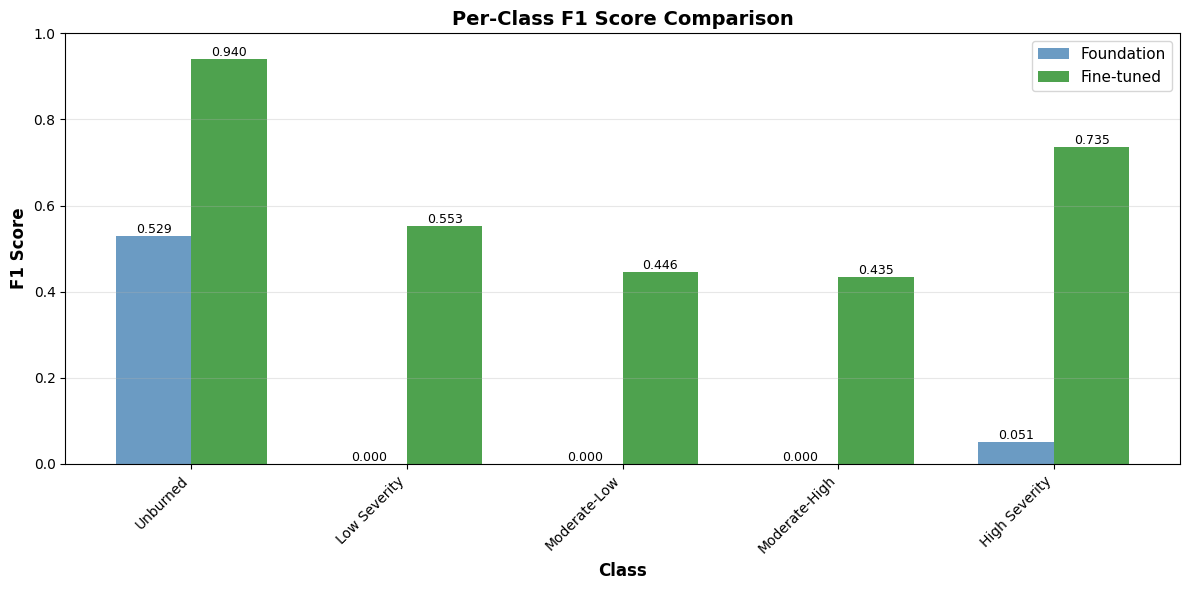

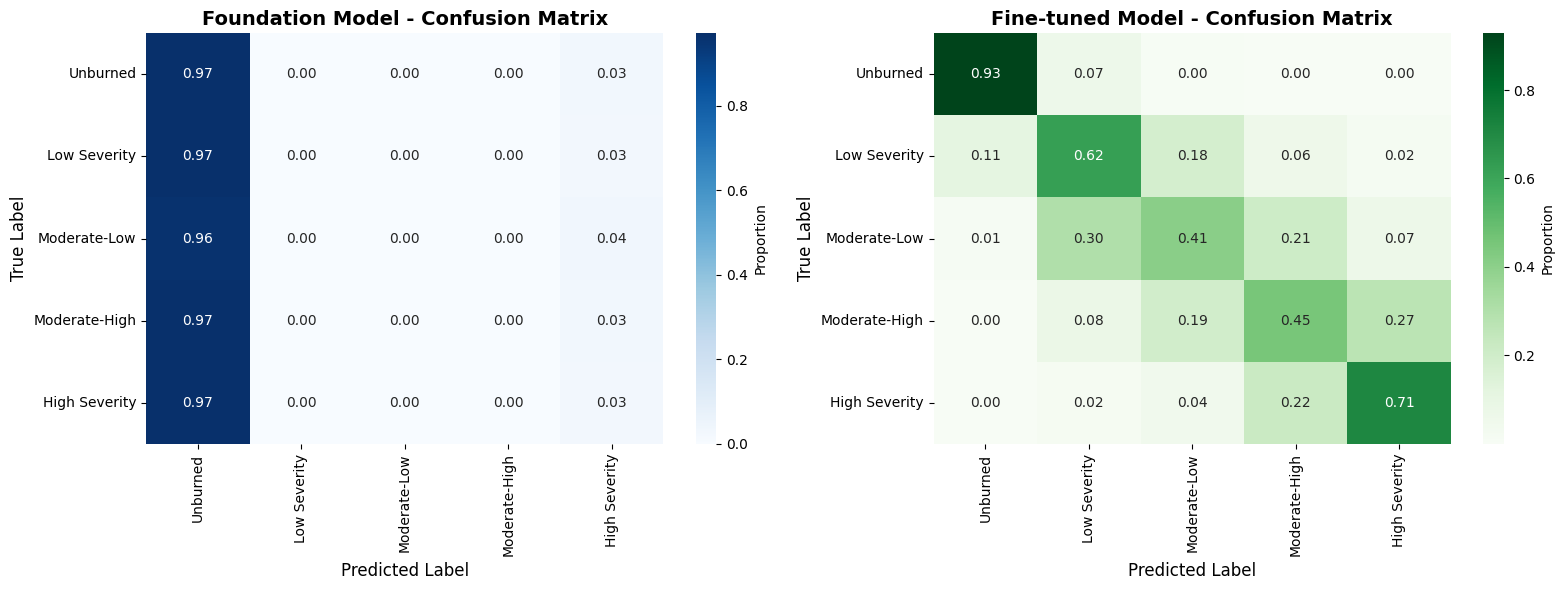


🖼️  Sample Predictions (Side-by-Side)


/tmp/ipython-input-4082407839.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


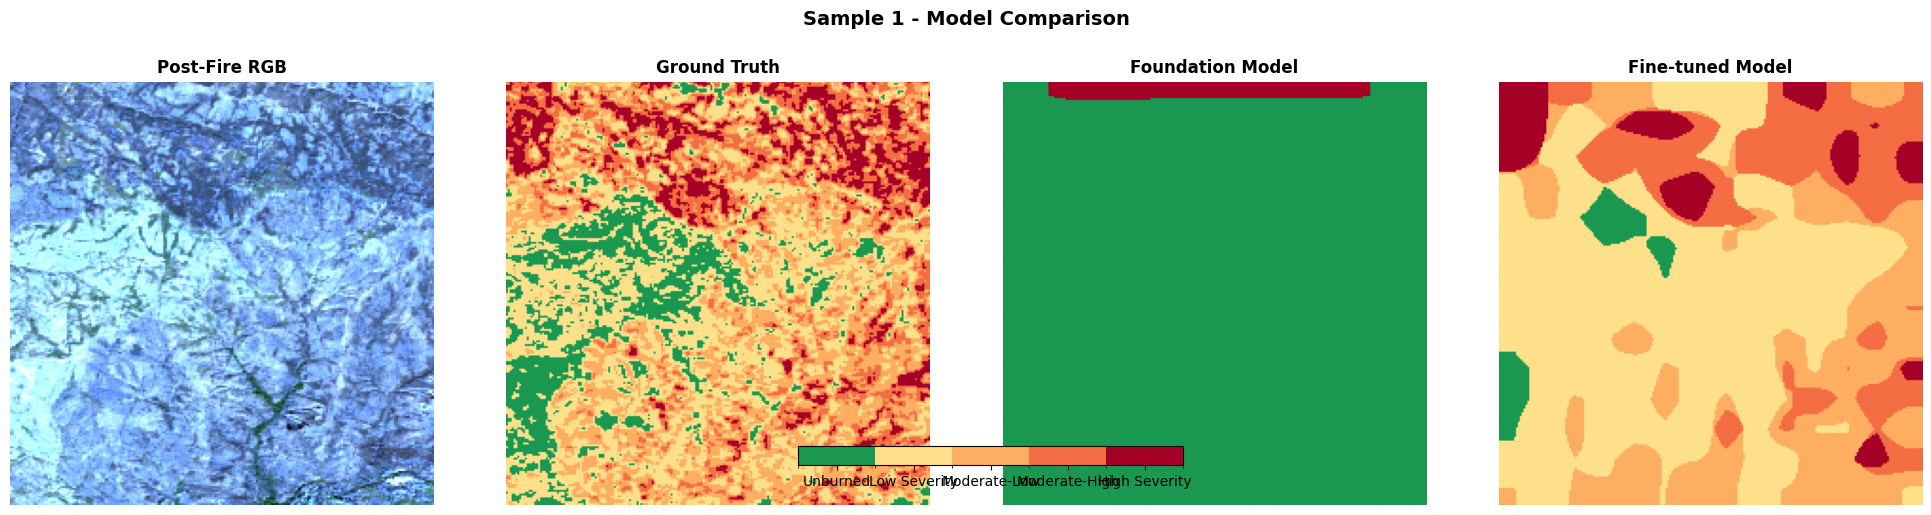

/tmp/ipython-input-4082407839.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


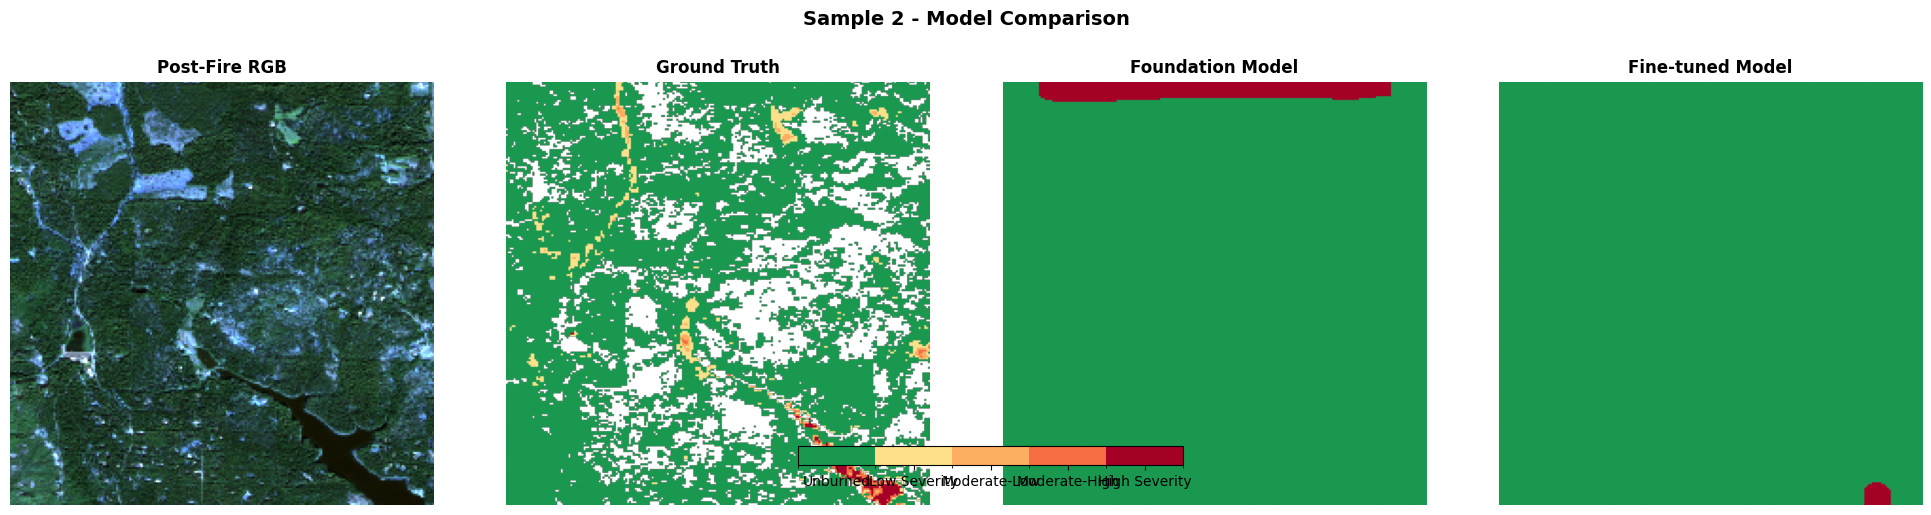

/tmp/ipython-input-4082407839.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


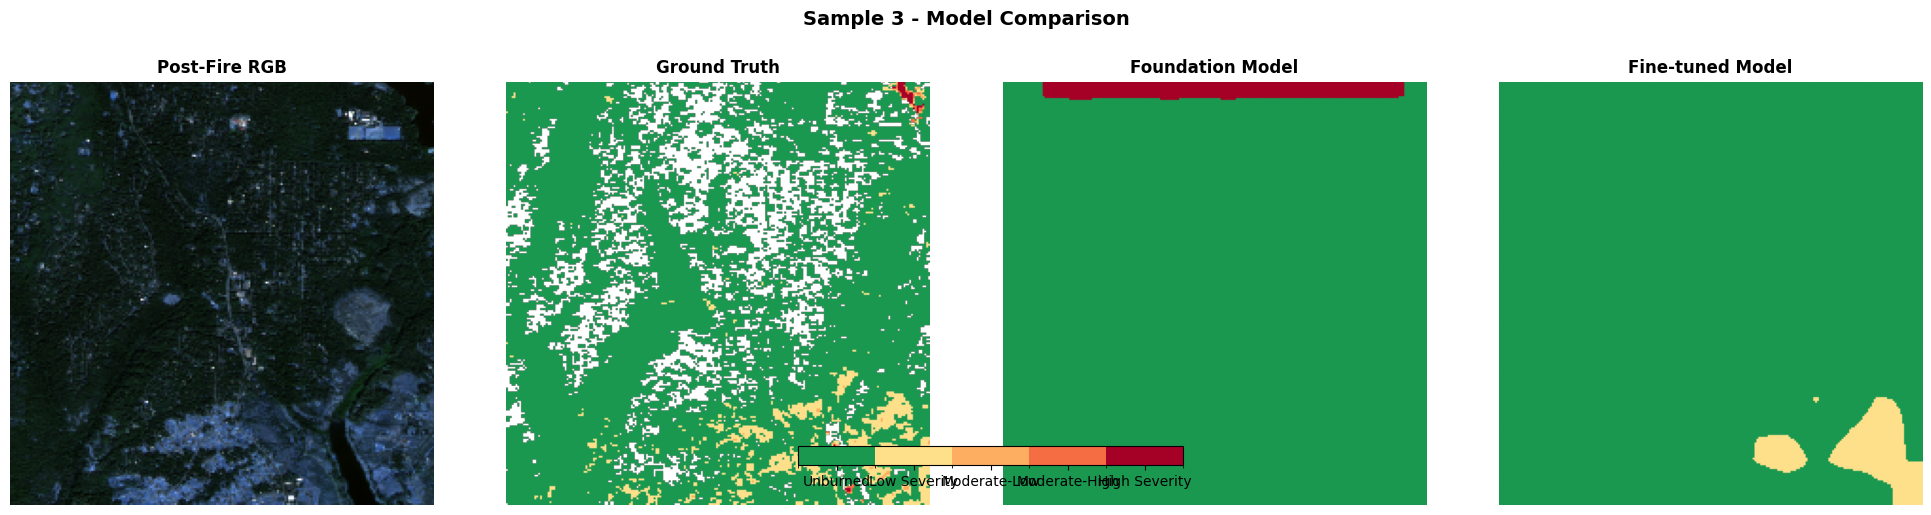

/tmp/ipython-input-4082407839.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


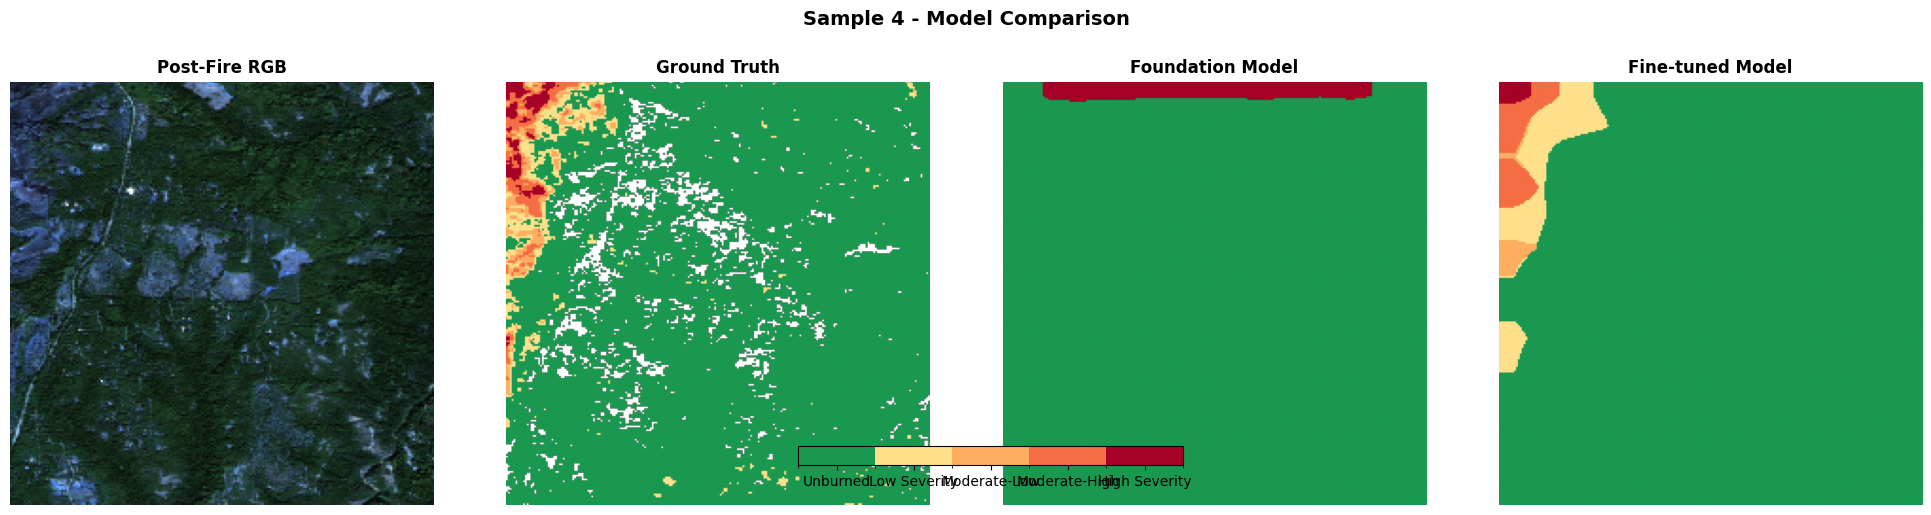

/tmp/ipython-input-4082407839.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


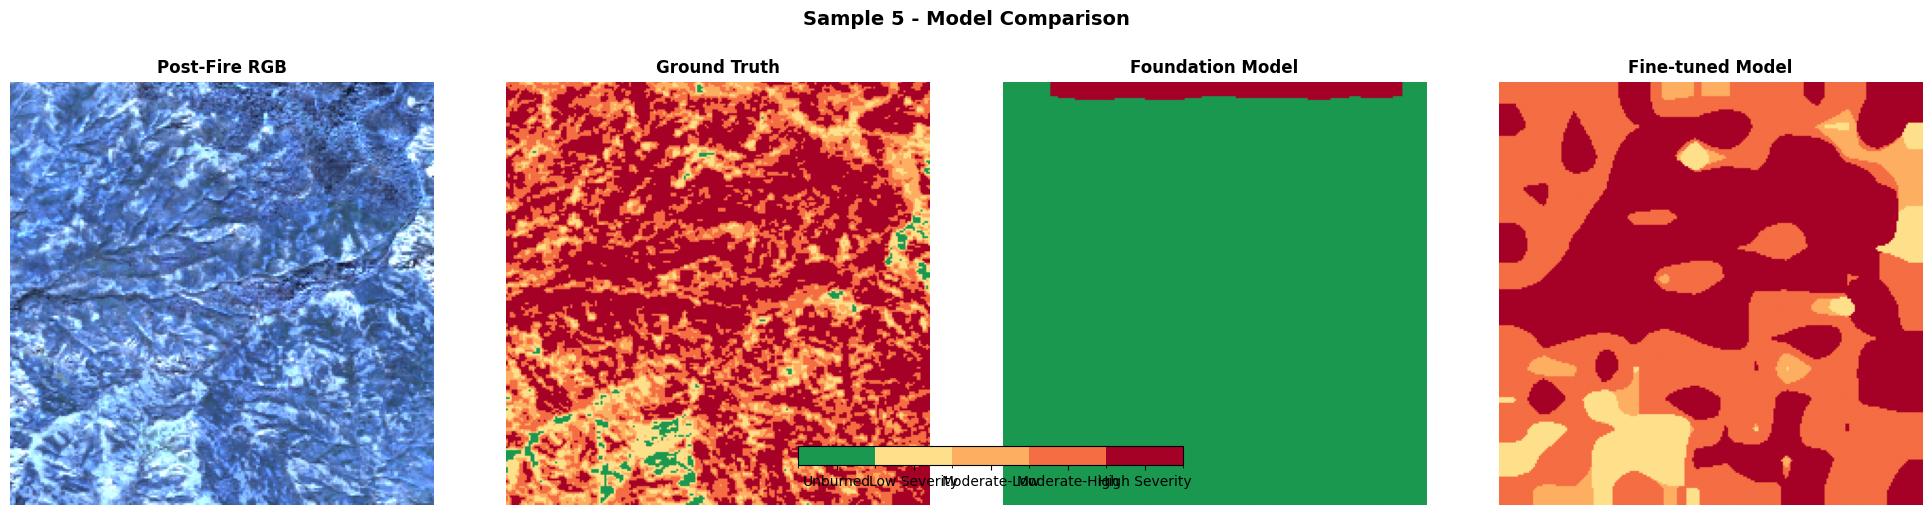

/tmp/ipython-input-4082407839.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


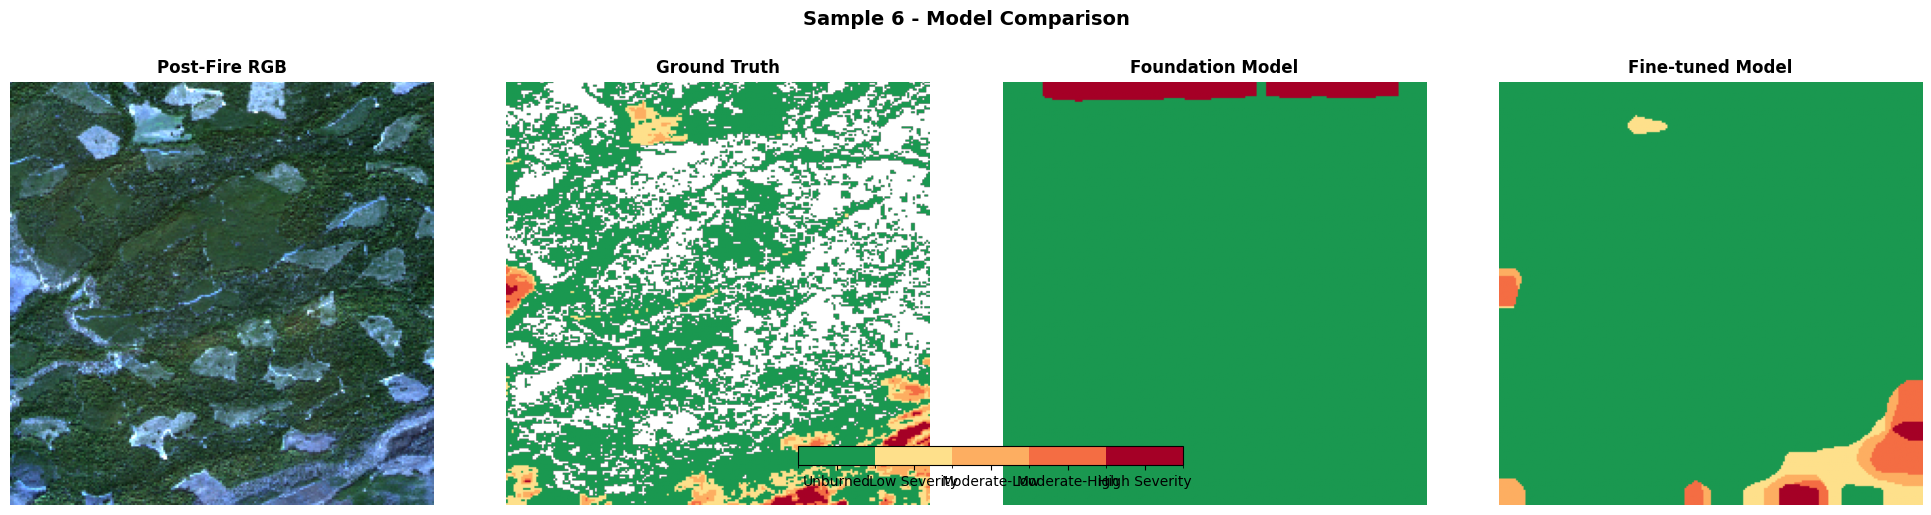


✅ Comparison complete!


In [35]:
# ============================================================================
# NOTEBOOK EXECUTION
# ============================================================================

if __name__ == "__main__":
    """
    Run this in your Jupyter/Colab notebook after training

    Required:
    - FireSeverityDataModule class
    - PrithviFireSegmentation class
    - compute_class_weights function
    - Trained model checkpoint
    """

    # Update these paths for your setup
    ComparisonConfig.DATA_DIR = "/content/data/prithvi_data_final_withdelta"
    ComparisonConfig.FINETUNED_CHECKPOINT = "/content/drive/MyDrive/FIRE ANALYSIS OUTPUT/prithvi-delta-epoch=26-val_loss=1.435.ckpt"
    ComparisonConfig.NUM_FRAMES = 3  # 3 for delta, 2 for baseline

    # Run comparison
    main()
